# <center>CITS5508 Lab sheet 4 Project 2</center>

**Name:** Alastair Mory<br>
**Student number:** 21120848<br>


<br><b>Contents</b><br>
[1 Data Reading, Visualisation and Statistics](#1)<br>

[2 Train test split](#2)<br>

[3 3 Random forrest regressor](#3)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Grid Search](#3.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Regressor fitting and predicting](#3.2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Raw error histograms](#3.3)<br>

[4 Feature importance trimming](#4)<br>

[5 Conclusion and discussion](#5)<br>


In [1]:
from typing import Any

from IPython.display import display, HTML

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, PredefinedSplit, train_test_split


# Data reading, visualisation and statistics<a name="1">

In [2]:
attribute_names = [
    'Sex',
    'Length',
    'Diameter',
    'Height',
    'Whole weight',
    'Shucked weight',
    'Viscera weight',
    'Shell weight',
    'Rings',
]

# Read data in
data = pd.read_csv('abalone.data', names=attribute_names)

# Display example rows
data.head()


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


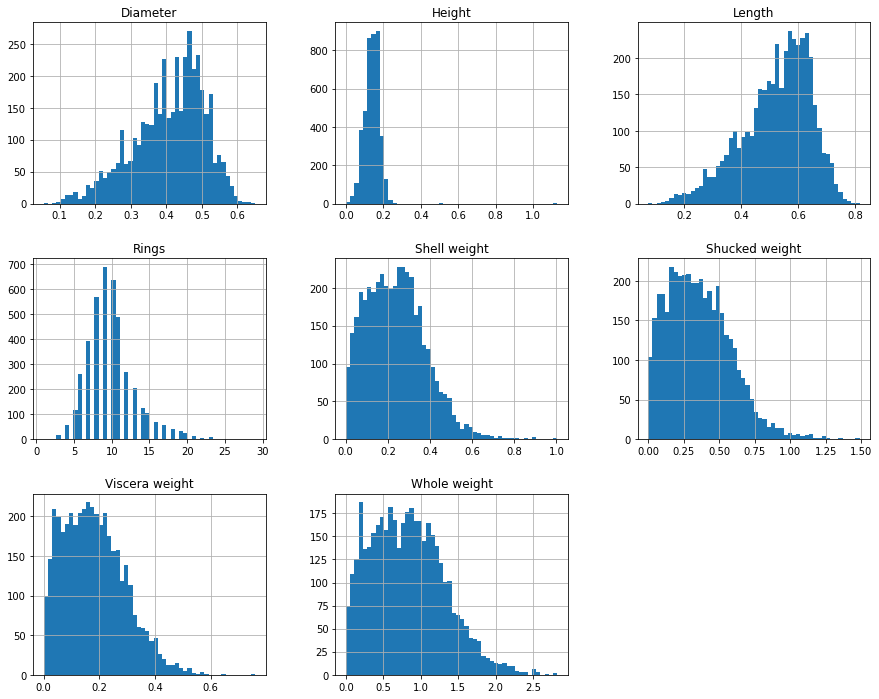

In [3]:
# Histogram of numerical features
_ = data.hist(bins=50, figsize=(15,12))


In [4]:
# Statistics for numerical features
data.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


From the above histograms and statistics we can see that most parameter distributions are skewed to some degree (whether negatively, e.g. diameter and length or positively e.g. weight) and that the 'Rings' parameter consists only of integer values.

# 2 Train test split<a name="2">
    
Random forests are not sensitive to feature scaling, so no normalisation of data was performed, only a 85/15 train/test split.

In [5]:
# Perform 85/15 train test split
y = data['Rings']

x = data.drop(columns=['Rings', 'Sex'])

train_x, test_x, train_y, test_y= train_test_split(x, y,
                                                   test_size=0.15,
                                                   train_size=0.85)

train_x = train_x.reset_index(drop=True)
test_x = test_x.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)
test_y = test_y.reset_index(drop=True)


# 3 Random forrest regressor<a name="3">

In [6]:
# Several helper functions to clean up code in later cells.

def get_results(regressor,  # untrained regressor,
                  train_x: pd.DataFrame, train_y: pd.Series,
                  test_x: pd.DataFrame, test_y: pd.Series):
    """
    Fit and run staged predictions for given regressor
    """    
    # Train regressor
    regressor.fit(train_x, train_y)
    
    y_train_pred = np.round(regressor.predict(train_x))
    y_test_pred = np.round(regressor.predict(test_x))

    return (y_train_pred, y_test_pred)


def print_mse(train_true, train_pred, test_true, test_pred):
    """Print MSE table from results"""
    train_mse = mean_squared_error(train_true, train_pred)
    test_mse = mean_squared_error(test_true, test_pred)
    row_names = ["Training MSE", "Testing MSE"]
    mse_table = pd.DataFrame(data=([train_mse, test_mse]),
                             index=row_names)
    html_table = mse_table.to_html(float_format=lambda a: str(round(a,4)),
                                   header=False,
                                   justify="left")
    print("Regressor mean squared errors:")
    display(HTML(html_table))

    
def print_trimmed_mse(true,  # Actual y values: [train, test]
                      orig,  # Original predictions: [train, test]
                      trim   # Trimmed feature predictions: [train, test]
             ):
    """Print MSE table from results"""
    mse = [[mean_squared_error(true[0], orig[0]),
                mean_squared_error(true[0], trim[0])],
               [mean_squared_error(true[1], orig[1]),
                mean_squared_error(true[1], trim[1])
               ]]
    row_names = ["Training MSE", "Testing MSE"]
    col_names = ["Original Features", "Trimmed Features"]
    mse_table = pd.DataFrame(data=mse,
                             index=row_names,
                             columns=col_names)
    html_table = mse_table.to_html(float_format=lambda a: str(round(a,4)),
                                   justify="left")
    print("Regressor mean squared errors:")
    display(HTML(html_table))

    
def raw_error_hist(train_y, test_y, train_pred, test_pred, trim_train_pred=None, trim_test_pred=None):
    
    def get_bar_heights(train_y, train_pred, test_y, test_pred, x_vals):
        y_train_re = train_pred - train_y
        y_test_re = test_pred - test_y
        
        y_train = bar_heights_from_errors(x_vals, y_train_re)
        y_test = bar_heights_from_errors(x_vals, y_test_re)
        
        return (y_train, y_test)
    
    def bar_heights_from_errors(x_vals, x_counts):
        bar_heights = []
        for x in x_vals:
            bar_heights.append((x_counts == x).sum())
        return bar_heights

    show_trimmed = trim_train_pred is not None and trim_test_pred is not None
    min_x = min(train_pred - train_y)
    max_x = max(train_pred - train_y)
    x = np.arange(min_x, max_x)  # X axis values
    
    y1_train, y1_test = get_bar_heights(train_y, train_pred, test_y, test_pred, x)
    if show_trimmed:
        y2_train, y2_test = get_bar_heights(train_y, trim_train_pred, test_y, trim_test_pred, x)
    fig, ax = plt.subplots(ncols=2,figsize=(15, 5))
    ax1 = ax[0]
    ax2 = ax[1]
    
    width = 0.4  # Bar widths
    
    if not show_trimmed:
        rects1 = ax1.bar(x, y1_train, width, label='All feat.')
        rects2 = ax2.bar(x, y1_test, width, label='All feat.')
    if show_trimmed:
        rects1 = ax1.bar(x - width/2, y1_train, width, label='All feat.')
        rects2 = ax1.bar(x + width/2, y2_train, width, label='Trimmed')
        rects3 = ax2.bar(x - width/2, y1_test, width, label='All feat.')
        rects4 = ax2.bar(x + width/2, y2_test, width, label='Trimmed')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    fig.suptitle('Histograms of Raw Errors', fontsize=16)
    ax1.set_xlabel('Raw Error')
    ax1.set_xticks(np.arange(min_x, max_x,))
    ax1.set_ylabel('Occurrences')
    ax1.set_title('Training Raw Errors')
    ax2.set_xlabel('Raw Error')
    ax2.set_xticks(np.arange(min_x, max_x,))
    ax2.set_ylabel('Occurrences')
    ax2.set_title('Testing Raw Errors')
    if show_trimmed:
        ax1.legend()
        ax2.legend()
    


## Grid Search <a name=3.1/>

Here we perform a grid search of several hyperparameters to find the best combination for the random forest regressor as it is quicker and more reliable than searching through hyperparameters manually. This can take 10-30 seconds to complete.

In [7]:
param_grid = {
    "n_estimators": [25, 250],
    "max_features": [0.2, 0.5, 1],
    "min_samples_leaf": [1, 10]
}

regressor = RandomForestRegressor()
reg = GridSearchCV(regressor, param_grid)
_ = reg.fit(x, y)

In [8]:
df_data = np.transpose([reg.cv_results_['mean_test_score'],
                        [d['n_estimators'] for d in reg.cv_results_['params']],
                        [d['min_samples_leaf'] for d in reg.cv_results_['params']],
                        [d['max_features'] for d in reg.cv_results_['params']]])
results = pd.DataFrame(data=df_data,
                       columns=['score', 'n_estimators', 'min_samples_leaf', 'max_features'])
# print(results)
print("Results sorted by score:")
print(results.sort_values(by='score', ascending=False))
print("")
print(f"Best score: {reg.best_score_:.5f}")
print(f"Best parameters: {reg.best_params_}")


Results sorted by score:
       score  n_estimators  min_samples_leaf  max_features
7   0.466386         250.0              10.0           0.5
6   0.461780          25.0              10.0           0.5
5   0.452598         250.0               1.0           0.5
1   0.446132         250.0               1.0           0.2
9   0.441996         250.0               1.0           1.0
4   0.432497          25.0               1.0           0.5
8   0.423021          25.0               1.0           1.0
11  0.422223         250.0              10.0           1.0
3   0.421249         250.0              10.0           0.2
2   0.417371          25.0              10.0           0.2
0   0.416888          25.0               1.0           0.2
10  0.415267          25.0              10.0           1.0

Best score: 0.46639
Best parameters: {'max_features': 0.5, 'min_samples_leaf': 10, 'n_estimators': 250}


## Regressor fitting and predicting <a name=3.2/>

In [9]:
reg_args = {  # Arguments to be used by regressor
    'n_estimators': 250,
    'max_features': 0.5,
    'min_samples_leaf': 10
}

regressor = RandomForestRegressor(**reg_args)
train_pred, test_pred = get_results(regressor, train_x, train_y, test_x, test_y)
print_mse(train_y, train_pred, test_y, test_pred)

Regressor mean squared errors:


Training MSE,3.4575
Testing MSE,4.5869


## Raw error histograms <a name=3.3/>

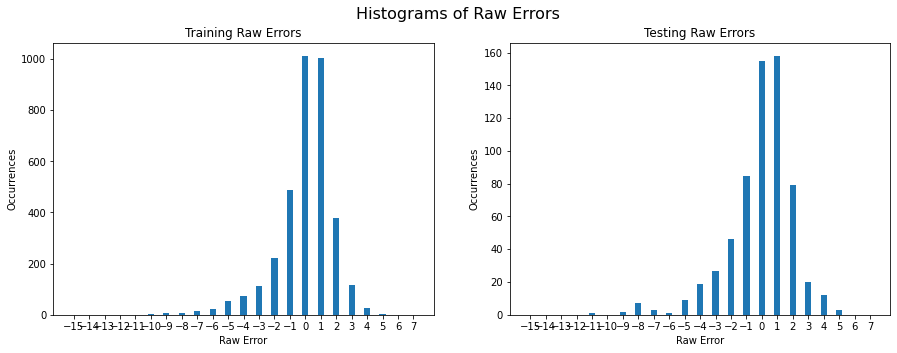

In [10]:
raw_error_hist(train_y, test_y, train_pred, test_pred)

# 4 Feature importance trimming<a name="4">

In [11]:
feature_importance = pd.DataFrame(data=regressor.feature_importances_,
                                  index=train_x.columns)
feature_importance = feature_importance.sort_values(by=0, axis='rows', ascending=False)
print("Feature importances:")
print(feature_importance)
print(f"\nIf we remove the least important feature (Length), the remaining features retain {sum(feature_importance[0][0:-1]) * 100:.2f}% feature importance.")

Feature importances:
                       0
Shell weight    0.399820
Height          0.159558
Shucked weight  0.128473
Whole weight    0.109907
Viscera weight  0.089949
Diameter        0.074951
Length          0.037341

If we remove the least important feature (Length), the remaining features retain 96.27% feature importance.


In [12]:
train_x_trim = train_x.drop(columns=['Length'])
test_x_trim = test_x.drop(columns=['Length'])

regressor_trim = RandomForestRegressor(**reg_args)
train_trim_pred, test_trim_pred = get_results(regressor, train_x_trim, train_y, test_x_trim, test_y)
print_trimmed_mse([train_y, test_y], [train_pred, test_pred], [train_trim_pred, test_trim_pred])

Regressor mean squared errors:


,Original Features,Trimmed Features
Training MSE,3.4575,3.4524
Testing MSE,4.5869,4.5343


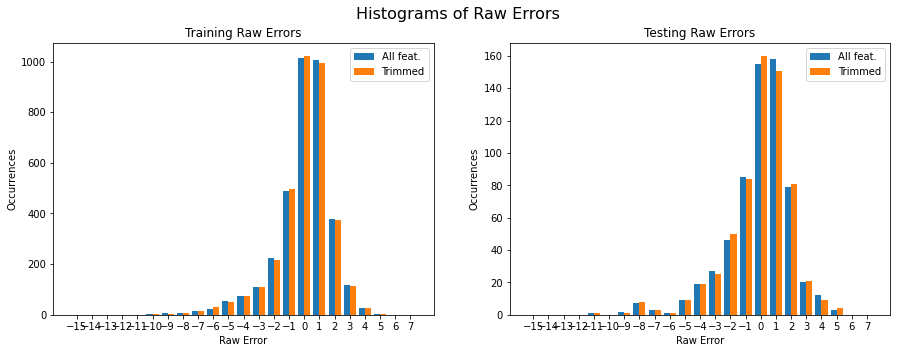

In [13]:
raw_error_hist(train_y, test_y, train_pred, test_pred, train_trim_pred, test_trim_pred)

# 5 Conclusion and discussion <a name="5">

    
The hyperparameters for the random forest regressor (RFR) were selected by grid search, which showed both increasing the number of estimators and reducing the number of features considered at each split improved the regressor's ability to generalise, as demonstrated by a train MSE much closer to the test MSE and a ~10% MSE improvement for the test set over default RFR hyperparameters.
    
Dimensionality reduction was done manually by removing the least important feature (Length) after observing it had a roughly 4% feature importance. The removal of this feature led to a small but likely insigificant increase in test set MSE (~2% from 5.5 to 5.6 in my case).
    
Looking at the histograms of raw errors for both the trianing and testing sets we observe significant negative skewness (i.e. a long negative tail in the raw prediction error distribution), but a positive prediction bias (i.e. the regressor is more likely to over rather than under predict the number of rings). Both of these can observations can be largely explained by the true distribution of rings in the dataset; it has a positive skew hence the predictions which likely have a lower skew will result in the distribution of raw errors having the inverse skew of the actual values.